<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-67115e1fe3d18e76'
PROJECT = 'qwiklabs-gcp-67115e1fe3d18e76'
REGION = 'us-east1'
SEQ_LEN = 50

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)
os.environ['TFVERSION'] = '1.8'

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [3]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


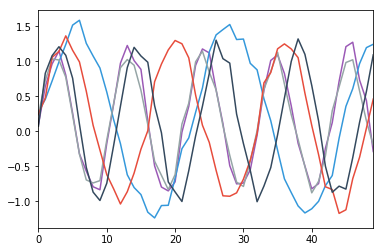

In [4]:
import numpy as np
import seaborn as sns

def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
  return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  sns.tsplot( create_time_series(), color=flatui[i%len(flatui)] );  # 5 series

In [5]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

import os
try:
  os.makedirs('data/sines/')
except OSError:
  pass
to_csv('data/sines/train-1.csv', 1000)  # 1000 sequences
to_csv('data/sines/valid-1.csv', 250)

In [6]:
!head -5 data/sines/*-1.csv

==> data/sines/train-1.csv <==
0.001695204440277187,0.5708668058962099,0.8862800794472074,1.10829403266726,1.2812804164122924,1.2447439648069216,1.3653773746717748,1.107434255919894,0.8494897277250948,0.6869474933499188,0.3789089980767555,0.16660525598414028,-0.06800555749390741,-0.4955278538806094,-0.7311677249780353,-0.8638222267620281,-0.9405820530610061,-1.0863230209191828,-0.8486101294161565,-0.7811712493569701,-0.41673916979028436,-0.29967441462685074,0.17731150538469645,0.3253662318441867,0.7137085245716478,0.9929734306476511,1.1884566510967343,1.3171942997018031,1.1384242266427473,1.2269061388356062,1.1412574300750005,0.8592907466171962,0.46770848865043785,0.10325329672241336,-0.12823862373980696,-0.3711385219891379,-0.5501047258635124,-0.9434960058729497,-0.8158598933635,-0.9894316045981398,-0.8108790812223506,-0.8705726013868155,-0.599592076905433,-0.2658534564594086,0.07052872984341732,0.47576573322997323,0.5698852422855949,1.0861703647191046,1.2639023064447361,1.29887415105

<h3> Train model locally </h3>

Make sure the code works as intended.

The `model.py` and `task.py` containing the model code is in <a href="sinemodel">sinemodel/</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set `--model` below to the appropriate model (linear,dnn,cnn,rnn,rnn2 or rnnN) and run it locally for a few steps to test the code.

In [11]:
%%bash
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
rm -rf $OUTDIR
gcloud ml-engine local train \
   --module-name=sinemodel.task \
   --package-path=${PWD}/sinemodel \
   -- \
   --train_data_path="${DATADIR}/train-1.csv" \
   --eval_data_path="${DATADIR}/valid-1.csv"  \
   --output_dir=${OUTDIR} \
   --model=rnn2 --train_steps=10 --sequence_length=$SEQ_LEN

W0904 07:26:16.067274 140564427396544 deprecation_wrapper.py:119] From sinemodel/model.py:23: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0904 07:26:16.067564 140564427396544 deprecation_wrapper.py:119] From sinemodel/model.py:23: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0904 07:26:16.068962 140564427396544 deprecation_wrapper.py:119] From sinemodel/model.py:242: The name tf.summary.FileWriterCache is deprecated. Please use tf.compat.v1.summary.FileWriterCache instead.

I0904 07:26:16.069149 140564427396544 run_config.py:528] TF_CONFIG environment variable: {u'environment': u'cloud', u'cluster': {}, u'job': {u'args': [u'--train_data_path=/home/jupyter/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/data/sines/train-1.csv', u'--eval_data_path=/home/jupyter/training-data-analyst/courses/machine_learning/deepdive/09_sequence/labs/data/sines/valid-1.csv', u'

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [9]:
import shutil
shutil.rmtree('data/sines', ignore_errors=True)
os.makedirs('data/sines/')
for i in range(0,10):
  to_csv('data/sines/train-{}.csv'.format(i), 1000)  # 1000 sequences
  to_csv('data/sines/valid-{}.csv'.format(i), 250)

In [10]:
%%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

CommandException: 1 files/objects could not be removed.
Copying file://data/sines/train-1.csv [Content-Type=text/csv]...
Copying file://data/sines/train-3.csv [Content-Type=text/csv]...
Copying file://data/sines/train-2.csv [Content-Type=text/csv]...
Copying file://data/sines/train-4.csv [Content-Type=text/csv]...
Copying file://data/sines/train-0.csv [Content-Type=text/csv]...
Copying file://data/sines/train-5.csv [Content-Type=text/csv]...                
Copying file://data/sines/valid-0.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-6.csv [Content-Type=text/csv]...                
Copying file://data/sines/train-6.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-9.csv [Content-Type=text/csv]...                
Copying file://data/sines/train-7.csv [Content-Type=text/csv]...                
Copying file://data/sines/valid-2.csv [Content-Type=text/csv]...
Copying file://data/sines/train-8.csv [Content-Type=text/csv]...                
Copying file://data

In [ ]:
%%bash
for MODEL in linear dnn cnn rnn rnn2 rnnN; do
  OUTDIR=gs://${BUCKET}/sinewaves/${MODEL}
  JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=sinemodel.task \
     --package-path=${PWD}/sinemodel \
     --job-dir=$OUTDIR \
     --staging-bucket=gs://$BUCKET \
     --scale-tier=BASIC_GPU \
     --runtime-version=$TFVERSION \
     -- \
     --train_data_path="gs://${BUCKET}/sines/train*.csv" \
     --eval_data_path="gs://${BUCKET}/sines/valid*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=3000 --sequence_length=$SEQ_LEN --model=$MODEL
done

## Monitor training with TensorBoard

Use this cell to launch tensorboard. If tensorboard appears blank try refreshing after 5 minutes

In [12]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/sinewaves'.format(BUCKET))

TensorBoard was started successfully with pid 5391. Click here to access it.

5391

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

## Results

Complete the below table with your own results! Then compare your results to the results in the solution notebook.

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| linear | 50 | 3000 | - | - |
| dnn | 50 | 3000 | - | - |
| cnn | 50 | 3000 | - | - |
| rnn | 50 | 3000 | - | - |
| rnn2 | 50 | 3000 | - | - |
| rnnN | 50 | 3000 | - | - |

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License